In [1]:
import os
import sys

In [2]:
#sys.path.insert(0, '/Users/marusy/Programming/another-fem-framework/')
sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0, '/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [3]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
np.set_printoptions(linewidth=500, precision=3)

In [6]:
c2p = Cell2PointsConverter(orders=[[4],[4,4]])

In [7]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [9]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(risky=1), method='svd')

Number of equations: 56
Number of degrees of freedom: 45
Strictly stitched_power: 3
Start solving strict part
[False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True  True  True  True  True]
Nullspace shape: (45, 5)
End solving strict part
NullspaceRank: 5


In [10]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()

In [11]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(risky=1),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [12]:
opt_solve.fit_opt(constraints=True, tr_fun_option='chebyshev', orders_forwards=1)

In [ ]:
opt_solve.restart_opt(tolerance=1e-3)

In [13]:
I_rl = np.array(opt_solve.I_rl_subbed_symm).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed_symm).astype(np.float64)

In [14]:
tr_f = np.vectorize(lambda x: x*(x-1)*(x-0.5))

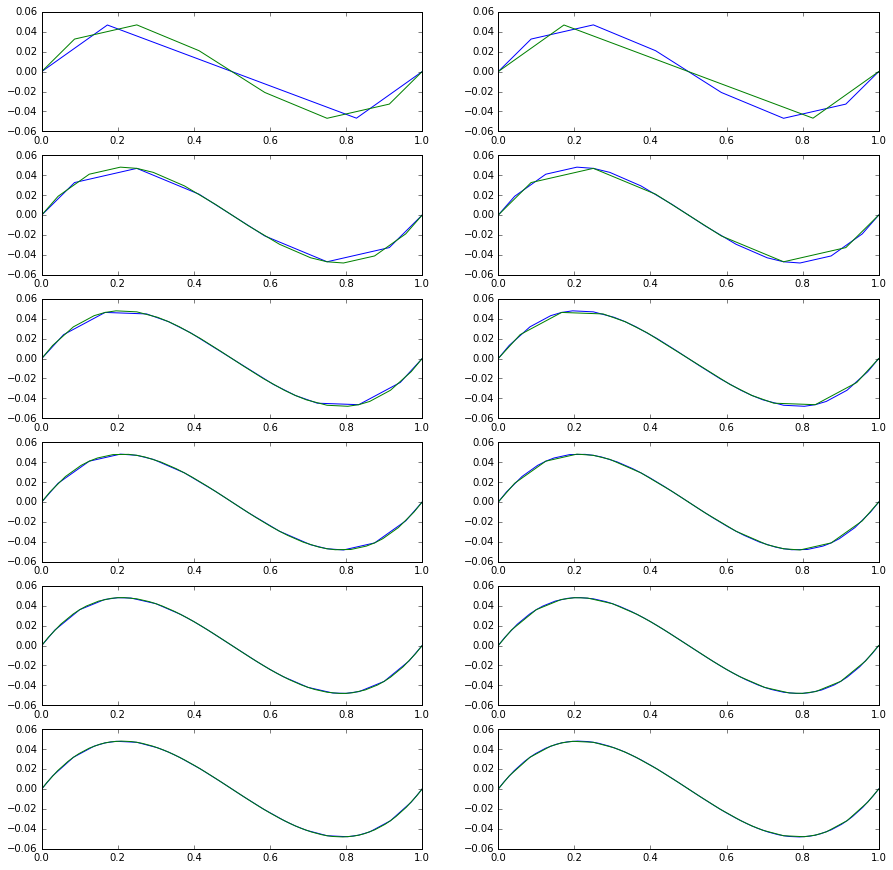

In [15]:
eps_l, eps_r = convergence_test(I_lr=I_lr,
                                I_rl=I_rl,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

In [ ]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

In [ ]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [16]:
np.abs(np.linalg.eigvals(np.dot(I_rl, I_lr)))

array([ 0.976,  1.   ,  1.   ,  1.   ,  1.   ])

In [17]:
np.save(arr=I_lr, file='../datasources/4_lr')
np.save(arr=I_rl, file='../datasources/4_rl')